# 5. Maze Q-learning

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (04/02/2025)

**Requirements:**
- Python 3 (tested on v3.13.1)
- Matplotlib (tested on v3.10.0)
- Numpy (tested on v2.2.1)
- collections, enum (Standard libraries for Python)

In [1]:
import random
from maze import *
from collections import defaultdict

In [2]:
# Seeding for reproducibility
np.random.seed(21)
random.seed(12)

### Creating the Maze environment

As in Notebook 4, we will reuse our Maze class and create a Maze environment with a given layout.

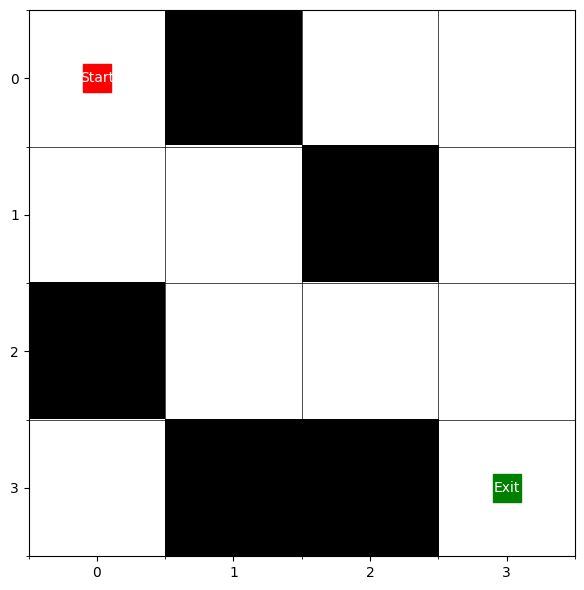

In [3]:
# Define a simple maze layout
# 0 = free, 1 = wall
maze_layout = np.array([[0, 1, 0, 0],
                        [0, 0, 1, 0],
                        [1, 0, 0, 0],
                        [0, 1, 1, 0]])

# Initialize the Maze environment
maze = Maze(maze = maze_layout, start_cell = (0, 0), exit_cell = (3, 3))

# Reset the maze
initial_state = maze.reset(start_cell = (0, 0))

# Display the maze
maze.draw_full_maze()

### Define the Q-Learning agent

Next, we will define our Q-learning agent, which interacts with the environment and learns an optimal policy using a Q-table. The Q-table is used by the agent to track the Q values of each action and each state, and to predict the best action in any given state.

Our QTableAgent class represents an AI agent that:
- Explores and exploits the environment.
- Uses a Q-table to store Q-values.
- Trains the Q-table using our Q-learning formula to learn the optimal Q-values and use them to find the optimal moves.
- Improves over time by balancing exploration and exploitation, with exporation decay.

Our agent class has the following attributes:
- environment: The Maze environment the agent interacts with.
- learning_rate = 0.1: the learning rate to use in the Q-learning formula.
- discount = 0.95: The discount factor (γ), controlling how much future rewards influence current decisions. A higher value (closer to 1) makes the agent focus more on long-term rewards.
- exploration_rate = 1.0: The initial probability of taking random actions instead of choosing the best-known action. Here, 1.0 means full exploration at the start.
- exploration_decay = 0.995: The rate at which exploration decreases over time. This ensures that the agent starts by exploring but gradually shifts to exploitation (following learned policies). You can see the evolution of the exploration rate, progressively shifting from 1 to 0 over the different episodes.

Our agent has the following methods
- init(self, maze, learning_rate, hidden_size): Initializes the agent with a given learning_rate, the hidden size to be userd in the Q-network that predicts Q-values for state-action pairs.
- q(self, state): Returns the Q-values for all possible actions in a given state. Uses the trained Q-table without modifying it.
- predict(self, state): Uses the Q-table to predict the best action (highest Q-value) in a given state.
- train(self, episodes, stop_at_convergence): The core training function for our Q-Learning agent. The agent plays the game multiple times (for a given number of episodes), learning optimal moves over time.

In the last method, the training process consists of looping through multiple episodes, and on each episode, the game unfolds by following these steps:
- First, we start from a random valid position in the maze (not necessarily the start)
- In each state, we select actions using ε-greedy strategy. If an exploration move is selected, use a random action. If an exploitation move is selected, use the predict method to choose the best move to use given our current understanding of the game.
- After a move is taken in a given state, we update Q-values using our Q-learning formula.

While looping through multiple episodes, we will track cumulative rewards, track our win rate over time, and perform a decay exploration to shift from exploring to exploiting. If the agent successfully reaches the goal from all states, training stops early.

Using this RL framework, our Q-learning model will eventually learn the true action-value function (Q(s, a)) that estimates future rewards and use that to decide on the optimal action to use in any state.

In [4]:
class QTableAgent:
    """
    Q-Learning agent using a Q-table.
    """
    def __init__(self, maze, learning_rate = 0.1, discount = 0.9, \
                 exploration_rate = 1.0, exploration_decay = 0.995):
        self.environment = maze
        self.lr = learning_rate
        self.gamma = discount
        self.epsilon = exploration_rate
        self.epsilon_decay = exploration_decay
        self.q_table = defaultdict(lambda: np.zeros(len(self.environment.actions)))

    def q(self, state):
        """
        Get Q-values for all actions for a given state.
        """
        return self.q_table[tuple(state.flatten())]

    def predict(self, state):
        """
        Policy: choose the action with the highest Q-value (exploitation).
        """
        return np.argmax(self.q(state))

    def train(self, episodes = 2000, stop_at_convergence = True):
        """
        Train the agent using Q-learning.
        """
        # Parameters for tracking training
        check_convergence_every = 5
        cumulative_reward_history = []
        win_history = []
        start_list = self.environment.empty.copy()

        for episode in range(1, episodes + 1):
            # Reset environment
            if not start_list:
                start_list = self.environment.empty.copy()
            start_cell = random.choice(start_list)
            start_list.remove(start_cell)
            state = self.environment.reset(start_cell)
            cumulative_reward = 0
            # Display
            if episode % 10 == 1 or episode == episodes:
                print(f"Episode: {episode} - Exploration rate: {self.epsilon}")
            while True:
                # Epsilon-greedy action selection
                if np.random.random() < self.epsilon:
                    # Exploration move, randomly deciding
                    action = random.choice(self.environment.actions)
                else:
                    # Exploitation move, using the Q-table to decide on the best move
                    action = self.predict(state)
                # Take action and observe result, update reward
                next_state, reward, status = self.environment.step(action)
                cumulative_reward += reward
                # Q-learning update rule
                best_next_q = np.max(self.q(next_state))
                target = reward + self.gamma * best_next_q if status == Status.PLAYING else reward
                self.q_table[tuple(state.flatten())][action] += self.lr * (target - self.q(state)[action])
                # Stop playing current episode if game has ended
                if status in (Status.WIN, Status.LOSE):
                    break
                state = next_state
            # Record cumulative rewards
            cumulative_reward_history.append(cumulative_reward)
            # Check convergence
            if episode % check_convergence_every == 0:
                w_all, win_rate = self.environment.check_win_all(self)
                win_history.append((episode, win_rate))
                if w_all and stop_at_convergence:
                    print("Won from all start cells. Stopped learning")
                    break
            # Decay exploration rate
            self.epsilon *= self.epsilon_decay
        # Upon ending return all infos
        return cumulative_reward_history, win_history

### Training the agent

Below, we will use the code above to create a Q-learning agent and train it by playing the game repeatedly. We will seed the code to ensure reproducibility.

In [5]:
# Create agent model
model = QTableAgent(maze, learning_rate = 0.1, discount = 0.9, exploration_rate = 1.0, exploration_decay = 0.99)

We then use our train() method to run 2,000 training episodes, where the agent plays the game repeatedly to eventually learn the best strategy.

In [6]:
# Train agent
h, w = model.train(episodes = 200, stop_at_convergence = True)

Episode: 1 - Exploration rate: 1.0
Episode: 11 - Exploration rate: 0.9043820750088043
Episode: 21 - Exploration rate: 0.8179069375972307
Episode: 31 - Exploration rate: 0.7397003733882802
Episode: 41 - Exploration rate: 0.6689717585696803
Episode: 51 - Exploration rate: 0.6050060671375365
Episode: 61 - Exploration rate: 0.5471566423907612
Episode: 71 - Exploration rate: 0.49483865960020695
Episode: 81 - Exploration rate: 0.44752321376381066
Episode: 91 - Exploration rate: 0.4047319726783239
Episode: 101 - Exploration rate: 0.36603234127322926
Episode: 111 - Exploration rate: 0.33103308832101386
Episode: 121 - Exploration rate: 0.29938039131233124
Episode: 131 - Exploration rate: 0.270754259511994
Episode: 141 - Exploration rate: 0.24486529903492946
Episode: 151 - Exploration rate: 0.22145178723886094
Episode: 161 - Exploration rate: 0.20027702685748935
Episode: 171 - Exploration rate: 0.18112695312597027
Episode: 181 - Exploration rate: 0.16380796970808745
Episode: 191 - Exploration ra

As shown in the curves below, the agent improves significantly over time, reaching a high win rate. The cumulative reward also increases steadily, indicating efficient pathfinding behavior. There are still some fluctuations in win rate, which suggest that the agent is still learning a few things about the game and has not yet achieved a perfect understanding of the game, but overall, it seems to be improving.

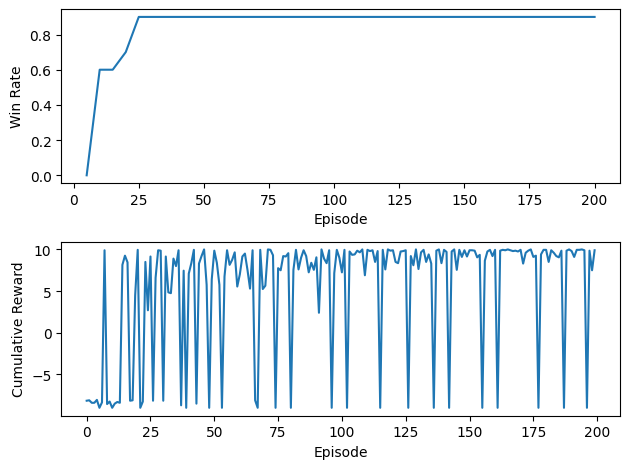

In [7]:
# Display training curves
fig, (ax1, ax2) = plt.subplots(2, 1, tight_layout = True)
ax1.plot(*zip(*w))
ax1.set_xlabel("Episode")
ax1.set_ylabel("Win Rate")
ax2.plot(h)
ax2.set_xlabel("Episode")
ax2.set_ylabel("Cumulative Reward")
plt.show()

### Testing the agent predictions capabilities

Below, we test our agent by checking which actions it produces in several cells of the maze. Since our predictions match expectations, it means the agent has learned the correct optimal path for our maze (at least for these cells!).

In [8]:
# Test predictions
# Expected: Best move for cell (0, 0) is down, which is index 3
pos1 = np.array((0, 0))
print(model.predict(pos1))
# Expected: Best move for cell (1, 2) is right, which is index 1
pos2 = np.array((1, 2))
print(model.predict(pos2))
# Expected: Best move for cell (3, 2) is down, which is index 3
pos3 = np.array((3, 2))
print(model.predict(pos3))

3
1
3


Finally, we can, visualize the entire maze and the best move to use in each walkable cell using our helper method below.

When starting in cell (0, 0), the agent is clearly able to identify the shortest path to exit the maze without hitting any walls!

There are however cells that are still problematic... For instance cell (0, 3) suggests to go left, which is wrong, but not the end of the world given that this cell is impossible to reach from (0, 0).

While this suggests that the Q-Learning agent has yet more to learn about the maze and the best moves to use, this agent is, however, capable of finding the shortest path from (0, 0) to (3, 3)!

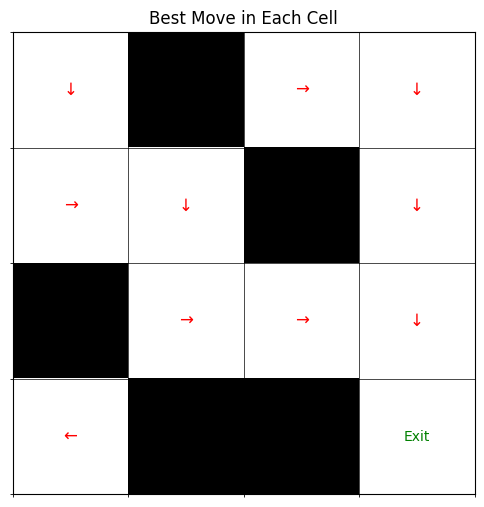

In [9]:
# Visualize best moves in each cell after training
maze.visualize_best_moves(model)